# Keras tuner 

Documentation: [Link](https://keras-team.github.io/keras-tuner/)

Hyperparameter methods: [Link](https://keras-team.github.io/keras-tuner/documentation/hyperparameters/#example-building-a-model-using-hyperparameters)



## Libraries

In [128]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.reset_defaults()

### Keras tuner installation and loading

In [129]:
!pip install -q -U keras-tuner

In [130]:
import kerastuner as kt
from kerastuner.tuners import RandomSearch,Hyperband

## Dataset

item_id :  15776
output_train_class [item_id] :  [1]
output_train_class_onehot [item_id] :  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


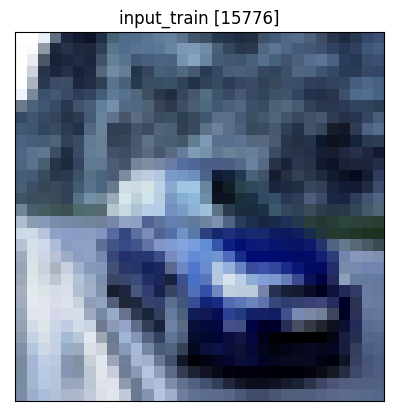

In [131]:
mnist=tf.keras.datasets.cifar10
(input_train, output_train_class),(input_test, output_test_class) = mnist.load_data()

input_train = input_train/255.0
input_test = input_test/255.0

output_train_class_onehot=tf.keras.utils.to_categorical(output_train_class,10)
output_test_class_onehot=tf.keras.utils.to_categorical(output_test_class,10)

item_id=np.random.randint(len(input_train))

print('item_id : ',item_id)
print('output_train_class [item_id] : ',output_train_class[item_id])
print('output_train_class_onehot [item_id] : ',output_train_class_onehot[item_id,:])

plt.imshow(input_train[item_id,:,:])
plt.title('input_train [' + str(item_id)+ ']')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

## 1: optimizing the VGG network

In [132]:
loss='categorical_crossentropy'
metrics=['accuracy']
validtrain_split_ratio=0.2
max_epochs=20
batch_shuffle=True
dropout_ratio = 0.3
batch_size=500

def network(hp):

  optimizer_type=Adam(lr=hp.Choice('learning_rate',values=[1e-2,1e-3,1e-4]))
  
  num_hidden_nodes=hp.Int('units',min_value=128,max_value=264,step=64)
#Conv2D(filters=32,   kernel_size=(3, 3),   strides=(1, 1),   padding='same', activation)(down_01) 
#down_01 = MaxPooling2D((2, 2),   strides=(2, 2))(down_01)

  input_shape=(32, 32, 3)
  inputs=Input(shape=input_shape)
  down_01 = Conv2D(filters=32,   kernel_size=(3, 3),   strides=(1, 1),   padding='same')(inputs) 
  down_01 = Activation('relu')(down_01)
  down_01 = MaxPooling2D((2, 2),   strides=(2, 2))(down_01)

  down_01 = Conv2D(filters=64,   kernel_size=(3, 3),   strides=(1, 1),   padding='same')(down_01) 
  down_01 = Activation('relu')(down_01)
  down_01 = MaxPooling2D((2, 2),   strides=(2, 2))(down_01)

  flatten=Flatten()(down_01)

  dense_01=Dense(num_hidden_nodes,activation=hp.Choice('dense_activation',values=['relu','tanh','sigmoid'],default='relu'))(flatten)
  dense_01 = Dropout(dropout_ratio)(dense_01)
  dense_02=Dense(10)(dense_01)
  outputs=Activation('softmax')(dense_02)

  model=Model(inputs=inputs,outputs=outputs)
  model.compile(optimizer=optimizer_type,loss=loss,metrics=metrics)

  return(model)

## Hyperparameters search

In [133]:
tuner=RandomSearch(network,objective='val_accuracy',max_trials=5,executions_per_trial=1,project_name='Hyperparameters',overwrite=True)

# or

#tuner=Hyperband(network,objective='val_accuracy',max_epochs=5,executions_per_trial=1,project_name='Hyperparameters',overwrite=True)

In [134]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 264, 'step': 64, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}


In [135]:
tuner.search(input_train,output_train_class_onehot,epochs=5,validation_split=0.2)

Trial 5 Complete [00h 00m 57s]
val_accuracy: 0.6291999816894531

Best val_accuracy So Far: 0.6916999816894531
Total elapsed time: 00h 04m 45s
INFO:tensorflow:Oracle triggered exit


In [136]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best parameters')
print('# of hidden units: ',best_hps.get('units'))
print('Learning rate: ',best_hps.get('learning_rate'))
print('Activation function: ',best_hps.get('dense_activation'))

Best parameters
# of hidden units:  128
Learning rate:  0.001
Activation function:  sigmoid


In [137]:
tuner.results_summary()

Results summary
Results in ./Hyperparameters
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001
units: 128
dense_activation: sigmoid
Score: 0.6916999816894531
Trial summary
Hyperparameters:
learning_rate: 0.001
units: 128
dense_activation: tanh
Score: 0.690500020980835
Trial summary
Hyperparameters:
learning_rate: 0.0001
units: 192
dense_activation: tanh
Score: 0.6291999816894531
Trial summary
Hyperparameters:
learning_rate: 0.0001
units: 256
dense_activation: tanh
Score: 0.6116999983787537
Trial summary
Hyperparameters:
learning_rate: 0.01
units: 192
dense_activation: tanh
Score: 0.10249999910593033


In [138]:
best_hp=tuner.get_best_hyperparameters()[0]
model=tuner.hypermodel.build(best_hp)

# or

#model=tuner.get_best_models(num_models=1)[0]

## Optimum network (further) training and results

In [139]:

history=model.fit(input_train,output_train_class_onehot,
                    epochs=max_epochs,
                    validation_split=validtrain_split_ratio,
                    shuffle=batch_shuffle,batch_size=batch_size)

Epoch 1/20
80/80 [==============================] - 3s 34ms/step - loss: 2.1885 - accuracy: 0.1963 - val_loss: 1.6431 - val_accuracy: 0.4291
Epoch 2/20
80/80 [==============================] - 2s 29ms/step - loss: 1.6251 - accuracy: 0.4158 - val_loss: 1.4618 - val_accuracy: 0.4818
Epoch 3/20
80/80 [==============================] - 2s 29ms/step - loss: 1.4406 - accuracy: 0.4855 - val_loss: 1.3141 - val_accuracy: 0.5389
Epoch 4/20
80/80 [==============================] - 2s 29ms/step - loss: 1.3268 - accuracy: 0.5279 - val_loss: 1.2381 - val_accuracy: 0.5687
Epoch 5/20
80/80 [==============================] - 2s 29ms/step - loss: 1.2506 - accuracy: 0.5491 - val_loss: 1.1876 - val_accuracy: 0.5854
Epoch 6/20
80/80 [==============================] - 2s 29ms/step - loss: 1.1849 - accuracy: 0.5784 - val_loss: 1.1477 - val_accuracy: 0.5984
Epoch 7/20
80/80 [==============================] - 2s 29ms/step - loss: 1.1427 - accuracy: 0.5968 - val_loss: 1.1152 - val_accuracy: 0.6158
Epoch 8/20
80

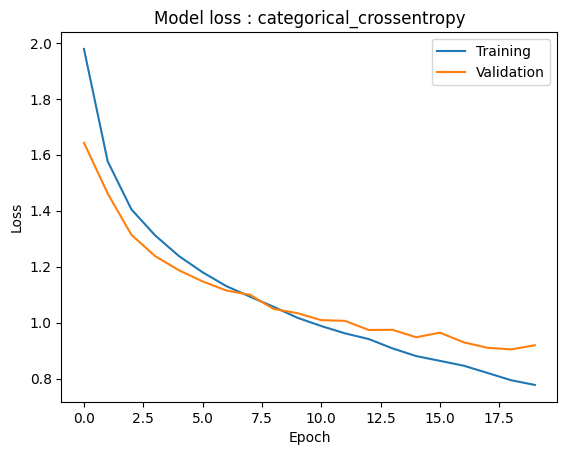

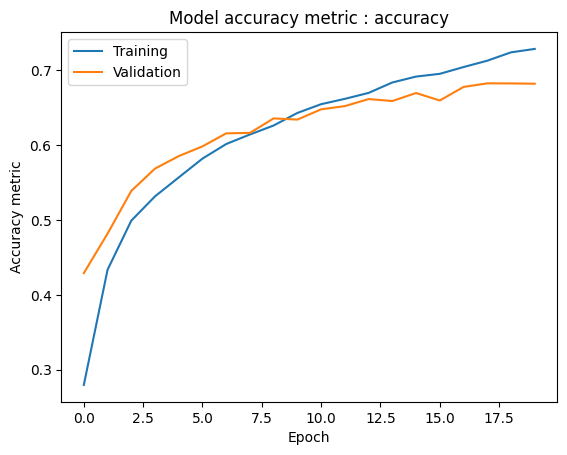

In [140]:
# model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss : '+loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history.history[metrics[0]]))
plt.plot(np.array(history.history['val_'+metrics[0]]))
plt.title('Model accuracy metric : '+metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='best')
plt.show()
plt.close()

### Test accuracy

In [141]:
print('* Evaluating the performance of the trained network on the unseen test dataset *\n')

evaluate_model=model.evaluate(x=input_test,y=output_test_class_onehot)
loss_metric=evaluate_model [0]
accuracy_metric=evaluate_model [1]


print('\nAccuracy: '+metrics[0]+': %0.3f'%accuracy_metric)
print('Loss: '+loss+': %0.3f'%loss_metric)

* Evaluating the performance of the trained network on the unseen test dataset *

313/313 [==============================] - 2s 5ms/step - loss: 0.9166 - accuracy: 0.6822

Accuracy: accuracy: 0.682
Loss: categorical_crossentropy: 0.917


### Confusion matrix

Text(0.5, 1.0, 'Training set')

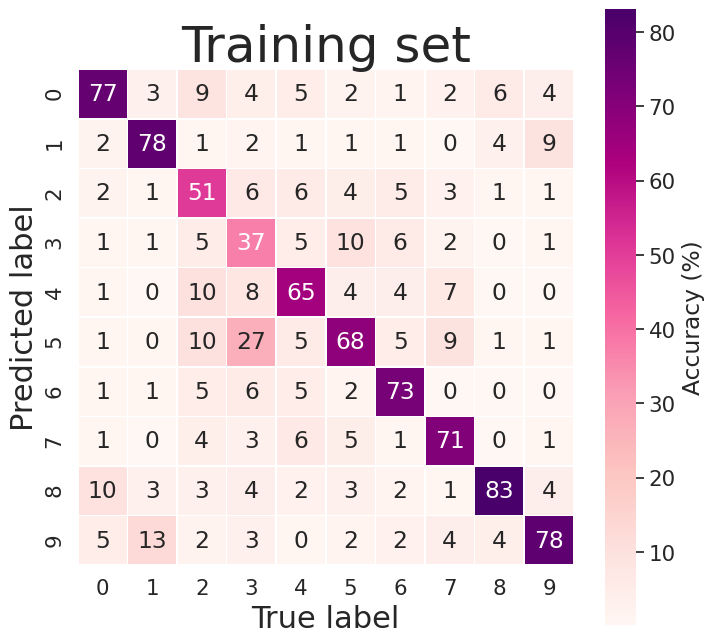

In [142]:
plt.figure(figsize=(8,8))

prediction=model(input_test,training=False)
prediction=prediction.numpy()
prediction=np.argmax(prediction,axis=1)

tstlbl=np.argmax(output_test_class_onehot,axis=1)

mat = confusion_matrix(tstlbl, prediction)
mat = mat*100/mat.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.4)
sns.heatmap(mat.T, square=True, annot=True, fmt='0.0f', cbar=True,cmap='RdPu',
            xticklabels=range(10),
            yticklabels=range(10),linewidths=0.5,
            cbar_kws={'label': 'Accuracy (%)'})
plt.xlabel('True label',fontsize=22)
plt.ylabel('Predicted label',fontsize=22)
plt.title('Training set',fontsize=36)

### Sample prediction

* Predicting the class of a given input *

test_id :  1505

output_predict_class_onehot [test_id]: 

 [[0.15938677 0.005218   0.64419043 0.11972971 0.01348975 0.00733116
  0.03523232 0.0027546  0.01040124 0.00226597]]

sum[output_predict_class_onehot [test_id]] :  1.0

output_predict_class [item_id] :  2

True label :  [2] 



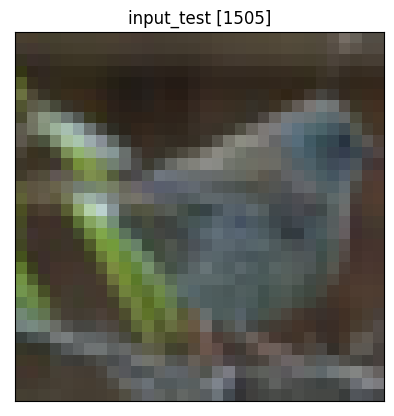

In [143]:
sns.reset_defaults()

print('* Predicting the class of a given input *\n')

test_id=np.random.randint(len(input_test))
input_predict=np.zeros(shape=(1,32,32,3))
input_predict[0,:,:]=input_test[test_id,:,:]
output_predict_class_onehot=model.predict(input_predict)
output_predict_class=np.argmax(output_predict_class_onehot[0])

print('test_id : ',test_id)
print('\noutput_predict_class_onehot [test_id]: \n\n',output_predict_class_onehot)
print('\nsum[output_predict_class_onehot [test_id]] : ',np.sum(output_predict_class_onehot))
print('\noutput_predict_class [item_id] : ',output_predict_class)
print('\nTrue label : ',output_test_class[test_id],'\n')


plt.imshow(input_test[test_id, :, :])
plt.title('input_test [' + str(test_id)+']')
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.show()

## 2: Changing the number of convolutional layers

In [145]:
loss='categorical_crossentropy'
metrics=['accuracy']
validtrain_split_ratio=0.2
max_epochs=20
batch_shuffle=True
dropout_ratio = 0.3
batch_size=500

def network(hp):

  optimizer_type=Adam(lr=1e-3)
  
  num_hidden_nodes=hp.Int('units',min_value=128,max_value=256,step=32)
#Conv2D(filters=32,   kernel_size=(3, 3),   strides=(1, 1),   padding='same', activation)(down_01) 
#down_01 = MaxPooling2D((2, 2),   strides=(2, 2))(down_01)

  input_shape=(32, 32, 3)
  inputs=Input(shape=input_shape)
  down_01=inputs

  for i in   range(hp.Int('num_layers', 1, 3)): 
    down_01 = Conv2D(filters=32*pow(2,i), kernel_size=(3, 3),   strides=(1, 1),padding='same', activation='relu')(down_01) 
    down_01 = MaxPooling2D((2, 2),   strides=(2, 2))(down_01) 

  flatten=Flatten()(down_01)

  dense_01=Dense(num_hidden_nodes,activation='relu')(flatten)
  dense_01 = Dropout(dropout_ratio)(dense_01)
  dense_02=Dense(10)(dense_01)
  outputs=Activation('softmax')(dense_02)

  model=Model(inputs=inputs,outputs=outputs)
  model.compile(optimizer=optimizer_type,loss=loss,metrics=metrics)

  return(model)

In [146]:
tuner=RandomSearch(network,objective='val_accuracy',max_trials=5,executions_per_trial=1,project_name='Hyperparameters',overwrite=True)


In [147]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}


In [148]:
tuner.search(input_train,output_train_class_onehot,epochs=5,validation_split=0.2)

Trial 5 Complete [00h 00m 55s]
val_accuracy: 0.6801999807357788

Best val_accuracy So Far: 0.7210000157356262
Total elapsed time: 00h 04m 46s
INFO:tensorflow:Oracle triggered exit


In [151]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best parameters')
print('# of hidden units: ',best_hps.get('units'))
print('Number of convolutional layers: ',best_hps.get('num_layers'))

Best parameters
# of hidden units:  160
Number of convolutional layers:  3


In [152]:
tuner.results_summary()

Results summary
Results in ./Hyperparameters
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 160
num_layers: 3
Score: 0.7210000157356262
Trial summary
Hyperparameters:
units: 160
num_layers: 2
Score: 0.6966000199317932
Trial summary
Hyperparameters:
units: 192
num_layers: 2
Score: 0.6930999755859375
Trial summary
Hyperparameters:
units: 128
num_layers: 2
Score: 0.6801999807357788
Trial summary
Hyperparameters:
units: 256
num_layers: 1
Score: 0.6366999745368958


In [153]:
best_hp=tuner.get_best_hyperparameters()[0]
model=tuner.hypermodel.build(best_hp)

In [154]:
history=model.fit(input_train,output_train_class_onehot,
                    epochs=max_epochs,
                    validation_split=validtrain_split_ratio,
                    shuffle=batch_shuffle,batch_size=batch_size)

Epoch 1/20
80/80 [==============================] - 4s 42ms/step - loss: 2.0428 - accuracy: 0.2449 - val_loss: 1.5564 - val_accuracy: 0.4428
Epoch 2/20
80/80 [==============================] - 3s 37ms/step - loss: 1.5607 - accuracy: 0.4301 - val_loss: 1.3825 - val_accuracy: 0.5113
Epoch 3/20
80/80 [==============================] - 3s 37ms/step - loss: 1.3815 - accuracy: 0.5060 - val_loss: 1.2772 - val_accuracy: 0.5509
Epoch 4/20
80/80 [==============================] - 3s 37ms/step - loss: 1.2908 - accuracy: 0.5345 - val_loss: 1.2168 - val_accuracy: 0.5664
Epoch 5/20
80/80 [==============================] - 3s 37ms/step - loss: 1.1943 - accuracy: 0.5764 - val_loss: 1.1059 - val_accuracy: 0.6141
Epoch 6/20
80/80 [==============================] - 3s 37ms/step - loss: 1.1372 - accuracy: 0.5986 - val_loss: 1.0922 - val_accuracy: 0.6193
Epoch 7/20
80/80 [==============================] - 3s 37ms/step - loss: 1.0739 - accuracy: 0.6227 - val_loss: 1.0572 - val_accuracy: 0.6338
Epoch 8/20
80

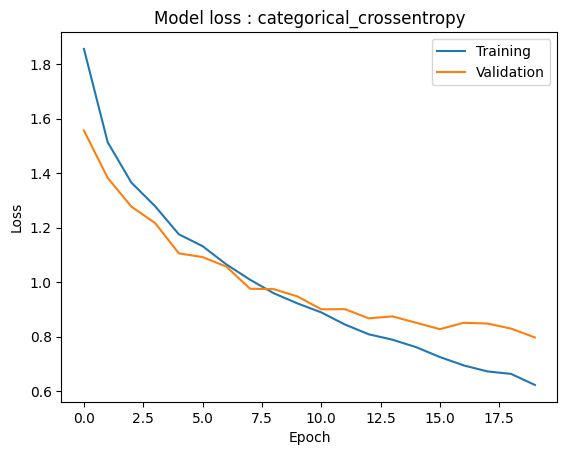

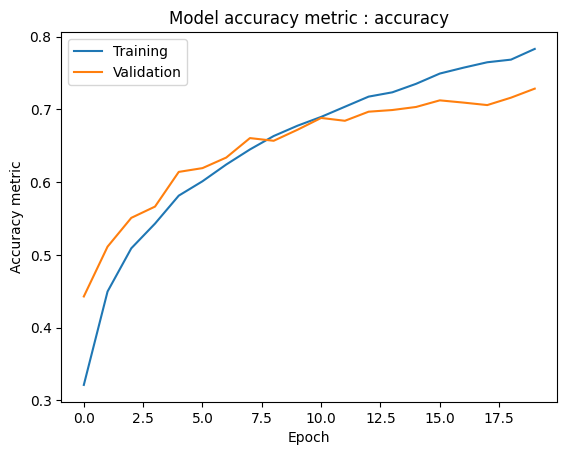

In [155]:
# model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss : '+loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history.history[metrics[0]]))
plt.plot(np.array(history.history['val_'+metrics[0]]))
plt.title('Model accuracy metric : '+metrics[0])
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='best')
plt.show()
plt.close()

In [156]:
print('* Evaluating the performance of the trained network on the unseen test dataset *\n')

evaluate_model=model.evaluate(x=input_test,y=output_test_class_onehot)
loss_metric=evaluate_model [0]
accuracy_metric=evaluate_model [1]


print('\nAccuracy: '+metrics[0]+': %0.3f'%accuracy_metric)
print('Loss: '+loss+': %0.3f'%loss_metric)

* Evaluating the performance of the trained network on the unseen test dataset *

313/313 [==============================] - 2s 5ms/step - loss: 0.8088 - accuracy: 0.7230

Accuracy: accuracy: 0.723
Loss: categorical_crossentropy: 0.809


Text(0.5, 1.0, 'Training set')

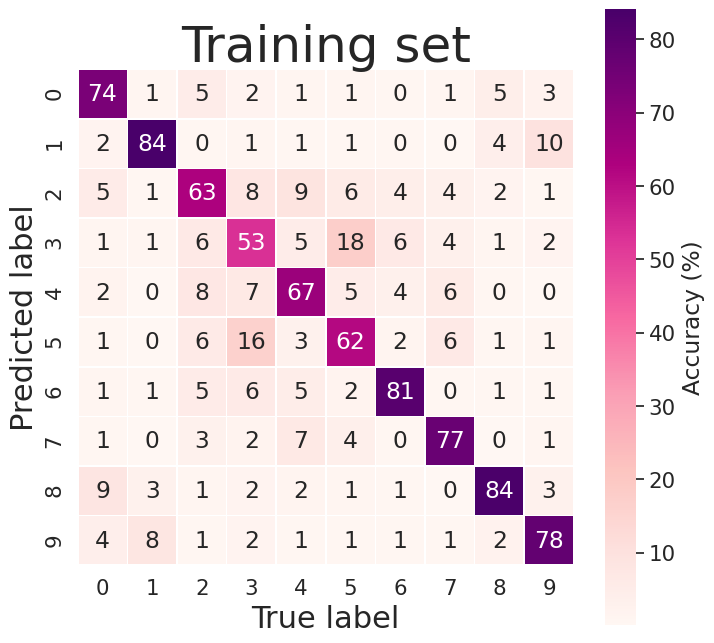

In [157]:
plt.figure(figsize=(8,8))

prediction=model(input_test,training=False)
prediction=prediction.numpy()
prediction=np.argmax(prediction,axis=1)

tstlbl=np.argmax(output_test_class_onehot,axis=1)

mat = confusion_matrix(tstlbl, prediction)
mat = mat*100/mat.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.4)
sns.heatmap(mat.T, square=True, annot=True, fmt='0.0f', cbar=True,cmap='RdPu',
            xticklabels=range(10),
            yticklabels=range(10),linewidths=0.5,
            cbar_kws={'label': 'Accuracy (%)'})
plt.xlabel('True label',fontsize=22)
plt.ylabel('Predicted label',fontsize=22)
plt.title('Training set',fontsize=36)